In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from numpy.random import shuffle 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sentiment_analysis_spanish import sentiment_analysis # Supervised Machine Learning Based Aproach

In [2]:
df_spotify = pd.read_csv('data.csv')
df_spotify['genre'].value_counts()

genre
0    1041
1     904
Name: count, dtype: int64

# Logistic regression

In [3]:
def balanced_accuracy(cm):
  """
  Returns the metrics of the model
  """
  sensitivity = cm[1,1]/(cm[1,1]+cm[0,1])
  specificity = cm[0,0]/(cm[1,0]+cm[0,0])
  return [sensitivity, specificity, (sensitivity + specificity)/2]

In [4]:
# Define the feature matrix X
fields = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_seg','positividad'] 
X = df_spotify[fields].values 
y = df_spotify['genre'] 
print(X.shape) 

scaler = MinMaxScaler() # maping of feature with MinMaxScaler. By default, this function map the values into [0,1]
scaler.fit(X) # maping paramiters
X = scaler.transform(X) 

regLog = LogisticRegression(penalty = None, class_weight='balanced', max_iter=10000) # Init the model with 10000 iterations

regLog.fit(X, y) # Select the parameters to fit the model
score = regLog.score(X,y) # Get the score of this model

ypred = regLog.predict(X) # get the prediction of the model with the features
cm = confusion_matrix(ypred, y) # do the confusion matrix with ypred and true y
metricas = balanced_accuracy(cm)

print('El score del modelo es de: {}'.format(round(score,4))) # Print the score of the model
print('Matriz de confusion del modelo es:')
print(cm)
print('Sensibilidad del modelo es de: {}'.format(round(metricas[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas[1],4)))
print('BA del modelo es de: {}'.format(round(metricas[2],4)))

(1945, 13)
El score del modelo es de: 0.8062
Matriz de confusion del modelo es:
[[858 194]
 [183 710]]
Sensibilidad del modelo es de: 0.7854
Especificidad del modelo es de: 0.8242
BA del modelo es de: 0.8048


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_train) # encuentro los parametros para el escaleo
X_train = scaler.transform(X_train) # aplico la transformacion

scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
scaler.fit(X_test) # encuentro los parametros para el escaleo
X_test = scaler.transform(X_test) # aplico la transformacion

#### IMPORTANTE: HAGO LA NORMALIZACION DE LOS DATOS POR SEPARADO EN LOS SETS DE TRAIN Y TEST

regLog = LogisticRegression(penalty = None, class_weight='balanced', max_iter=10000) # Inicializamos nuevamente el modelo
regLog.fit(X_train, y_train) # Ajustamos el modelo con los parámetros

score_train = regLog.score(X_train,y_train) # Calculamos el score
ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_train = balanced_accuracy(cm_train)

print('Para TRAIN set:')
print('El score del modelo es de: {}'.format(round(score_train,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_train)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_train[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas_train[1],4)))
print('BA del modelo es de: {}'.format(round(metricas_train[2],4)))
print('\n')

score_test= regLog.score(X_test,y_test) # Calculamos el score
ypred_test= regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
cm_test = confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
metricas_test = balanced_accuracy(cm_test)


print('Para TEST set:')
print('El score del modelo es de: {}'.format(round(score_test,4))) # Le pido que printee el score del modelo. Le pido que lo haga con 4 cifras significativas
print('Matriz de confusion del modelo es:')
print(cm_test)
print('Sensibilidad del modelo es de: {}'.format(round(metricas_test[0],4)))
print('Especificidad del modelo es de: {}'.format(round(metricas_test[1],4)))
print('BA del modelo es de: {}'.format(round(metricas_test[2],4)))

Para TRAIN set:
El score del modelo es de: 0.8193
Matriz de confusion del modelo es:
[[600 129]
 [117 515]]
Sensibilidad del modelo es de: 0.7997
Especificidad del modelo es de: 0.8368
BA del modelo es de: 0.8183


Para TEST set:
El score del modelo es de: 0.7312
Matriz de confusion del modelo es:
[[301 134]
 [ 23 126]]
Sensibilidad del modelo es de: 0.4846
Especificidad del modelo es de: 0.929
BA del modelo es de: 0.7068


# Optimización de hiperparámetros

Para este punto se graficara un mapa con las "balanced accuracy" del modelo para distintos valores de hiperparametros (regulacion y la potencia maxima a la cual seelevan las features), de esta forma viendo el resultado para el split de test se puede determinar que valor de regulacion nos devuelve el mejor resultado

In [6]:
def classifier(X,y,n,c):  # X es la matriz de features, y los labels, n-1 la potencia máxima en la que aparecerán los features, C es la constante de regularización

  X_temp = X
  for i in np.arange(2,n):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
  X = X_temp


  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_train) # encuentro los parametros para el escaleo
  X_train = scaler.transform(X_train) # aplico la transformacion

  scaler = MinMaxScaler() # primero creo un objeto MinMaxScaler. Por defecto, esto normaliza los datos al intervalo [0,1]
  scaler.fit(X_test) # encuentro los parametros para el escaleo
  X_test = scaler.transform(X_test) # aplico la transformacion

  regLog = LogisticRegression(penalty = 'l2', class_weight='balanced', C=c, max_iter=10000)
  # regLog = MLPClassifier(alpha=1, max_iter=1000)
  
  regLog.fit(X_train, y_train)

  ypred_train = regLog.predict(X_train) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_train = confusion_matrix(ypred_train, y_train) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_train = balanced_accuracy(cm_train)

  ypred_test = regLog.predict(X_test) # con esto obtengo la predicción de las etiquetas en base a mis datos
  cm_test= confusion_matrix(ypred_test, y_test) # primera entrada son las etiquetas predichas, segunda son las reales
  metricas_test = balanced_accuracy(cm_test)

  return metricas_train[2], metricas_test[2]

In [7]:
# Definamos la matriz X
campos = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_seg','positividad'] # Lista que contiene las features de interés
X = df_spotify[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = df_spotify['genre'] # Nuestra etiqueta sigue siende la misma de antes
print(X.shape) 


BA_train, BA_test = classifier(X,y,6,1)
print(BA_train, BA_test)

# aumento C

BA_train, BA_test = classifier(X,y,6,1000)
print(BA_train, BA_test)

# disminuyo C

BA_train, BA_test = classifier(X,y,6,0.0001)
print(BA_train, BA_test)

(1945, 13)
0.8256400691117569 0.8184931506849316
0.8678288142715422 0.8812082606787421
0.740749875597672 0.7267652221678229


In [8]:
n_values = np.arange(1,6) # rango de potencias maximas
c_values = np.arange(0.2,5,0.2) # rango de constantes de regularizacion

iterations = 100 # esto se puede poner en 100 para que no tarde mil años durante la clase

mean_BA_train = np.zeros((len(n_values),len(c_values))) #  los arrays con los balanced accuracy para cada combinacion de hiperparametros, para train y test
mean_BA_test = np.zeros((len(n_values),len(c_values)))

for xx,n in enumerate(n_values): # itero sobre n
    for yy,c in enumerate(c_values): # itero sobre c
      BA_test_temp = [] # variables temporales para ir poniendo los resultados a lo largo de las iteraciones
      BA_train_temp = []
      print([n,c]) # esto es para los ansiosos
      for it in np.arange(iterations): # itero
          BA_train, BA_test = classifier(X,y,n,c)  # calculo las balanced accuracy para esos hiperparametros
          BA_test_temp.append(BA_test) # agrego a las variables temporales
          BA_train_temp.append(BA_train)
      mean_BA_train[xx,yy] = np.mean(BA_train_temp) # calculo promedios
      mean_BA_test[xx,yy] = np.mean(BA_test_temp)

[np.int64(1), np.float64(0.2)]
[np.int64(1), np.float64(0.4)]
[np.int64(1), np.float64(0.6000000000000001)]
[np.int64(1), np.float64(0.8)]
[np.int64(1), np.float64(1.0)]
[np.int64(1), np.float64(1.2)]
[np.int64(1), np.float64(1.4000000000000001)]
[np.int64(1), np.float64(1.6)]
[np.int64(1), np.float64(1.8)]
[np.int64(1), np.float64(2.0)]
[np.int64(1), np.float64(2.2)]
[np.int64(1), np.float64(2.4000000000000004)]
[np.int64(1), np.float64(2.6000000000000005)]
[np.int64(1), np.float64(2.8000000000000003)]
[np.int64(1), np.float64(3.0000000000000004)]
[np.int64(1), np.float64(3.2)]
[np.int64(1), np.float64(3.4000000000000004)]
[np.int64(1), np.float64(3.6000000000000005)]
[np.int64(1), np.float64(3.8000000000000003)]
[np.int64(1), np.float64(4.0)]
[np.int64(1), np.float64(4.2)]
[np.int64(1), np.float64(4.4)]
[np.int64(1), np.float64(4.6000000000000005)]
[np.int64(1), np.float64(4.800000000000001)]
[np.int64(2), np.float64(0.2)]
[np.int64(2), np.float64(0.4)]
[np.int64(2), np.float64(0.600

Por último, grafico como me quedan las BA para cada combinación de hiperparametros, y puedo encontrar cual es la BA máxima para cada caso, y con qué hiperparámetros la obtengo.

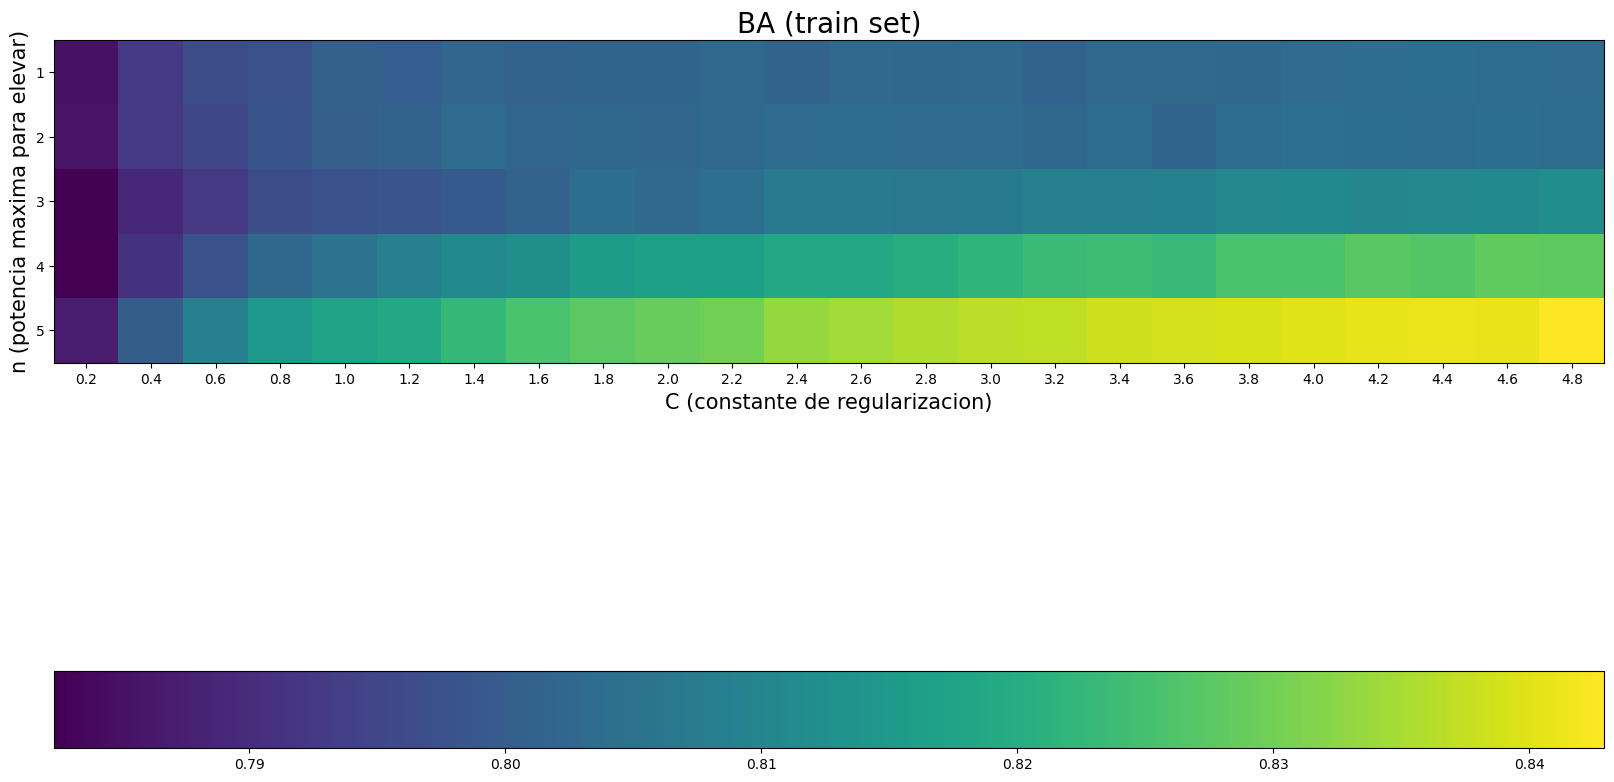

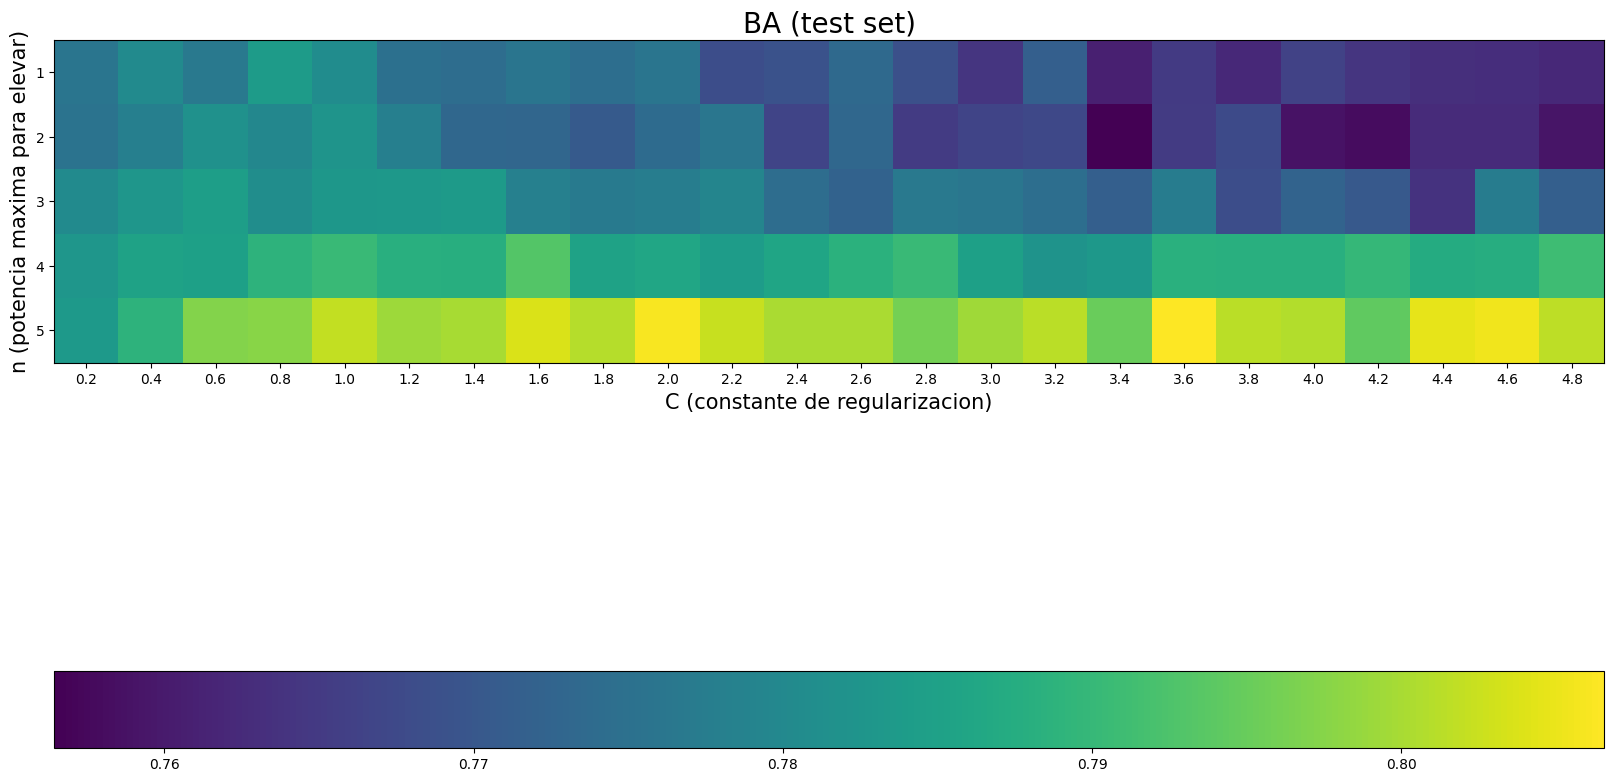

In [9]:
fig, ax = plt.subplots(1,1, figsize=(20,20))  # visualizacion train set
img = ax.imshow(mean_BA_train) # graficamos la matriz
y_label_list = n_values # estos son los ticks de los ejes
x_label_list = [round(value, 7) for value in c_values]
ax.set_xticks(np.arange(len(c_values))) # creo los ticks de los ejes
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list) # pongo los ticks de los ejes
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15) # le pongo nombre a ejes y titulo
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (train set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2) # la barra de colores donde no me moleste

fig, ax = plt.subplots(1,1, figsize=(20,20)) # visualizacion test set, ver comentarios para el caso train, es idéntico
img = ax.imshow(mean_BA_test)
y_label_list = n_values
x_label_list = [round(value, 7) for value in c_values]
ax.set_xticks(np.arange(len(c_values)))
ax.set_yticks(np.arange(len(n_values)))
ax.set_yticklabels(y_label_list)
ax.set_xticklabels(x_label_list)
plt.xlabel('C (constante de regularizacion)', fontsize=15)
plt.ylabel('n (potencia maxima para elevar)', fontsize=15)
plt.title('BA (test set)', fontsize=20)
fig.colorbar(img, orientation="horizontal", pad=0.2)


In [10]:
BA_train, BA_test = classifier(X,y,5,3.2)
print(BA_train, BA_test)

0.8342174348133098 0.8011399357081006


# Modelo nulo y curva ROC

Para asegurarse de que el modelo de clasificacion efectivamente clasifica se crea un "modelo nulo", para ello se randomizan las etiquetas al azar y se compara la performanse de este modelo nulo y el que seobtuvo prefviamente. 

In [11]:
skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = None, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores = np.concatenate((scores,probas_test[:,1]),axis=0)
    indices = np.concatenate((indices,test_index),axis=0)
    targets = np.concatenate((targets,y_test),axis=0)

print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))

Estos son los valores AUC para cada fold:
[0.8695640616693249, 0.8956651083722906, 0.840071185720357, 0.8952932426689334, 0.878426476838079]
Estos es el promedio de todos los AUC:
0.8758040150537969


Y ahora voy a todo pero permutando aleatoriamente todos los targets antes de empezar.

In [12]:
y_shuffled = y.copy() # creo una copia del vector de targets, porque shuffle lo pisa
shuffle(y_shuffled) # shuffleo

skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X, y_shuffled) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores_shuffled = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices_shuffled = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores
targets_shuffled = np.array([])    # aca es donde van a ir a parar los targets en el orden de la validacion cruzada

for train_index, test_index in skf.split(X, y_shuffled): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X[train_index], X[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y_shuffled[train_index], y_shuffled[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = None, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores_shuffled  = np.concatenate((scores_shuffled ,probas_test[:,1]),axis=0)
    indices_shuffled  = np.concatenate((indices_shuffled ,test_index),axis=0)
    targets_shuffled  = np.concatenate((targets_shuffled ,y_test),axis=0)



print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))

C:\Users\bruno\AppData\Local\Temp\ipykernel_11032\3815737450.py:2: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  shuffle(y_shuffled) # shuffleo


Estos son los valores AUC para cada fold:
[0.4912345941351466, 0.5559126646833829, 0.516322248193795, 0.5236134721631959, 0.533732057416268]
Estos es el promedio de todos los AUC:
0.5241630073183576


Ahora vamos a plotear las dos curvas ROC juntas para ver como se ven:

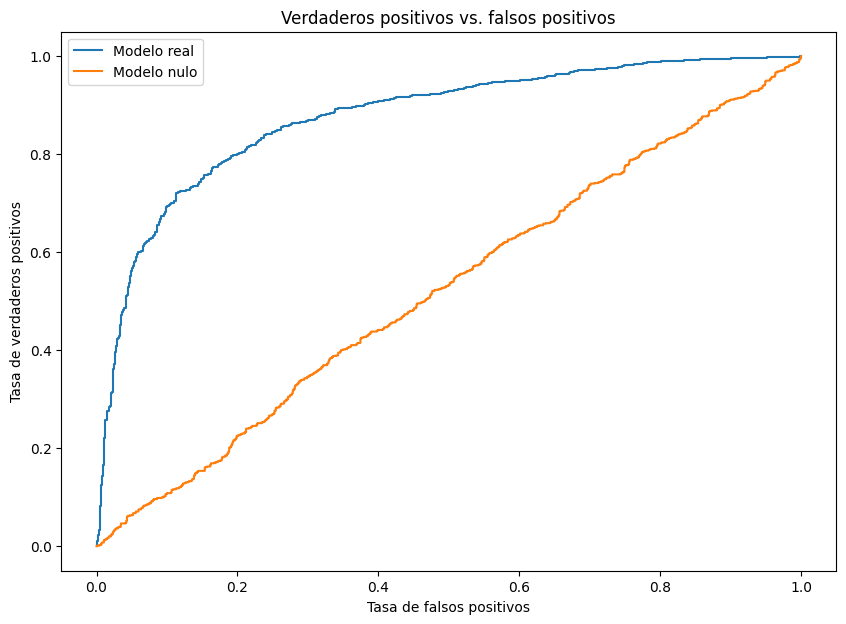

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# este codigo fue sacado del notebook de ROC AUC (clase 10) y sirve para visualizar la curva ROC

fpr, tpr, thresholds = roc_curve(targets, scores)
fpr_shuffled, tpr_shuffled, thresholds_shuffled = roc_curve(targets_shuffled, scores_shuffled)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr,tpr, label='Modelo real')
ax.plot(fpr_shuffled,tpr_shuffled, label='Modelo nulo')

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y
plt.legend()

Ahora si vemos una comparativa entre los falsos positivos y los verdaderos positivos se obtiene lo siguiente.

AUC entrenamiento: 0.9468
AUC evaluacion: 0.9197


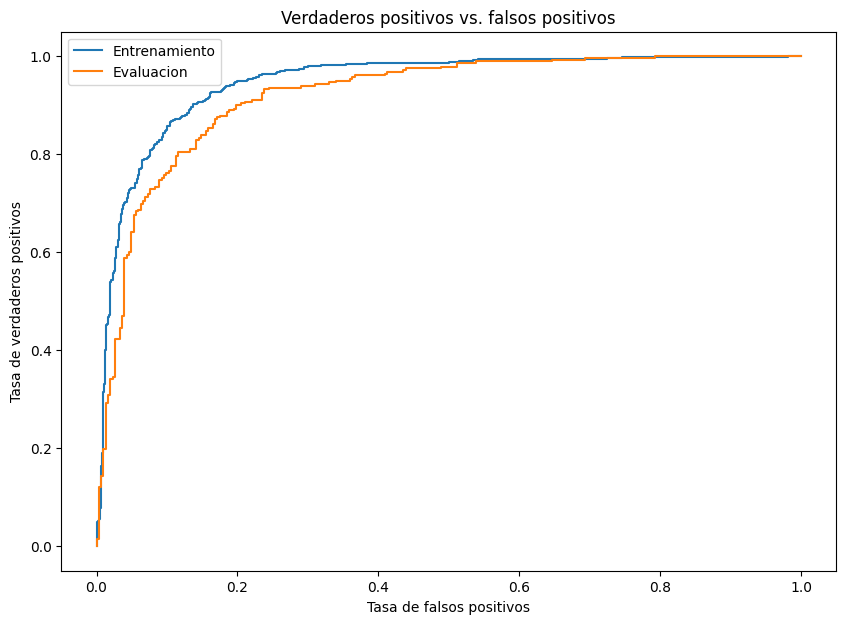

In [14]:
X_temp = X
for i in np.arange(2,6):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
X_1 = X_temp


X_train, X_test, y_train, y_test = train_test_split(X_1, y, test_size=0.3) # armo el split

scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_train)
X_train = scaler.transform(X_train)

scaler = MinMaxScaler() # escaleo por separado ambos sets
scaler.fit(X_test)
X_test = scaler.transform(X_test)

regLog_1 = LogisticRegression(penalty = None, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

probas_train = regLog_1.predict_proba(X_train)  # probabilidades con datos de entrenamiento
probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, probas_train[:,1]) # para plotear curva ROC con datos de entrenamiento
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de evaluacion

auc_train = roc_auc_score(y_train, probas_train[:,1]) #  AUC con datos de entrenamiento
auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

# para plotear ROC (codigo de un notebook anterior)

fig, ax = plt.subplots(figsize = (10,7))
ax.set_title('Verdaderos positivos vs. falsos positivos')
ax.plot(fpr_train,tpr_train, label = "Entrenamiento") # graficamos la curva ROC para el set de entrenamiento
ax.plot(fpr_test,tpr_test, label = "Evaluacion") # graficamos la curva ROC para el set de evaluacion

ax.set_xlabel('Tasa de falsos positivos') # Etiqueta del eje x
ax.set_ylabel('Tasa de verdaderos positivos') # Etiqueta del eje y

plt.legend()

print('AUC entrenamiento: {}'.format(round(auc_train,4)))
print('AUC evaluacion: {}'.format(round(auc_test,4)))

In [15]:
X_temp = X
for i in np.arange(2,6):
    X_temp = np.concatenate((X_temp,X**i), axis=1)
X_1 = X_temp


skf = StratifiedKFold(n_splits=5, shuffle=True) # 5 folds es un número típico si tenemos suficientes datos. Pedimos shuffle=True para que sea al azar la separación en subgrupos
skf.get_n_splits(X_1, y) # arma los folds a partir de los datos

auc_values = [] # aca es donde van a ir a parar los AUCs de cada fold
scores = np.array([])     # aca es donde van a ir a parar los scores computados para todos los casos
indices = np.array([])    # aca es donde van a ir a parar los indices correspondientes a las entradas de scores

for train_index, test_index in skf.split(X_1, y): # va generando los indices que corresponden a train y test en cada fold
    X_train, X_test = X_1[train_index], X_1[test_index] # arma que es dato de entrenamiento y qué es dato de evaluación
    y_train, y_test = y[train_index], y[test_index]     # idem con los targets

    regLog_1 = LogisticRegression(penalty = None, max_iter=10000) # Inicializamos nuevamente el modelo. max_iter es la cantidad de iteraciones maximas del algoritmo de optimizacion de parametros antes de detenerse.
    regLog_1.fit(X_train, y_train) # Ajustamos el modelo con los datos de entrenamiento

    probas_test = regLog_1.predict_proba(X_test)  # probabilidades con datos de evaluación
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:,1]) # para plotear curva ROC con datos de entrenamiento
    auc_test = roc_auc_score(y_test, probas_test[:,1]) #  AUC con datos de evaluación

    auc_values.append(auc_test)
    scores = np.concatenate((scores,probas_test[:,1]),axis=0)
    indices = np.concatenate((indices,test_index),axis=0)

print("Estos son los valores AUC para cada fold:")
print(auc_values)
print("Estos es el promedio de todos los AUC:")
print(np.mean(auc_values))
print("Estos son las probabilidades para cada sample:")
print(scores)
print("Esta es la forma en que quedaron ordenados las entradas del vector anterior (indices):")
print(indices)

Estos son los valores AUC para cada fold:
[0.8834928229665071, 0.8893433914152146, 0.8600722481937951, 0.8113312792180195, 0.8814014024649384]
Estos es el promedio de todos los AUC:
0.8651282288516949
Estos son las probabilidades para cada sample:
[0.27712791 0.29685774 0.27754572 ... 0.43151076 0.43083895 0.43364795]
Esta es la forma en que quedaron ordenados las entradas del vector anterior (indices):
[   2.    6.    7. ... 1938. 1939. 1943.]


# Otros Modelos

Por último, se evaluaran otros modelos como los son KNN, SVM,RandomForest y redes neuronales.

In [16]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# selección de modelos
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [17]:
names = ["KNN", "SVM lineal", "SVM RBF", "Árbol de decisión", "Random Forest", "Red neuronal"]

classifiers = [
    KNeighborsClassifier(7),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    ]

<Figure size 2000x800 with 0 Axes>

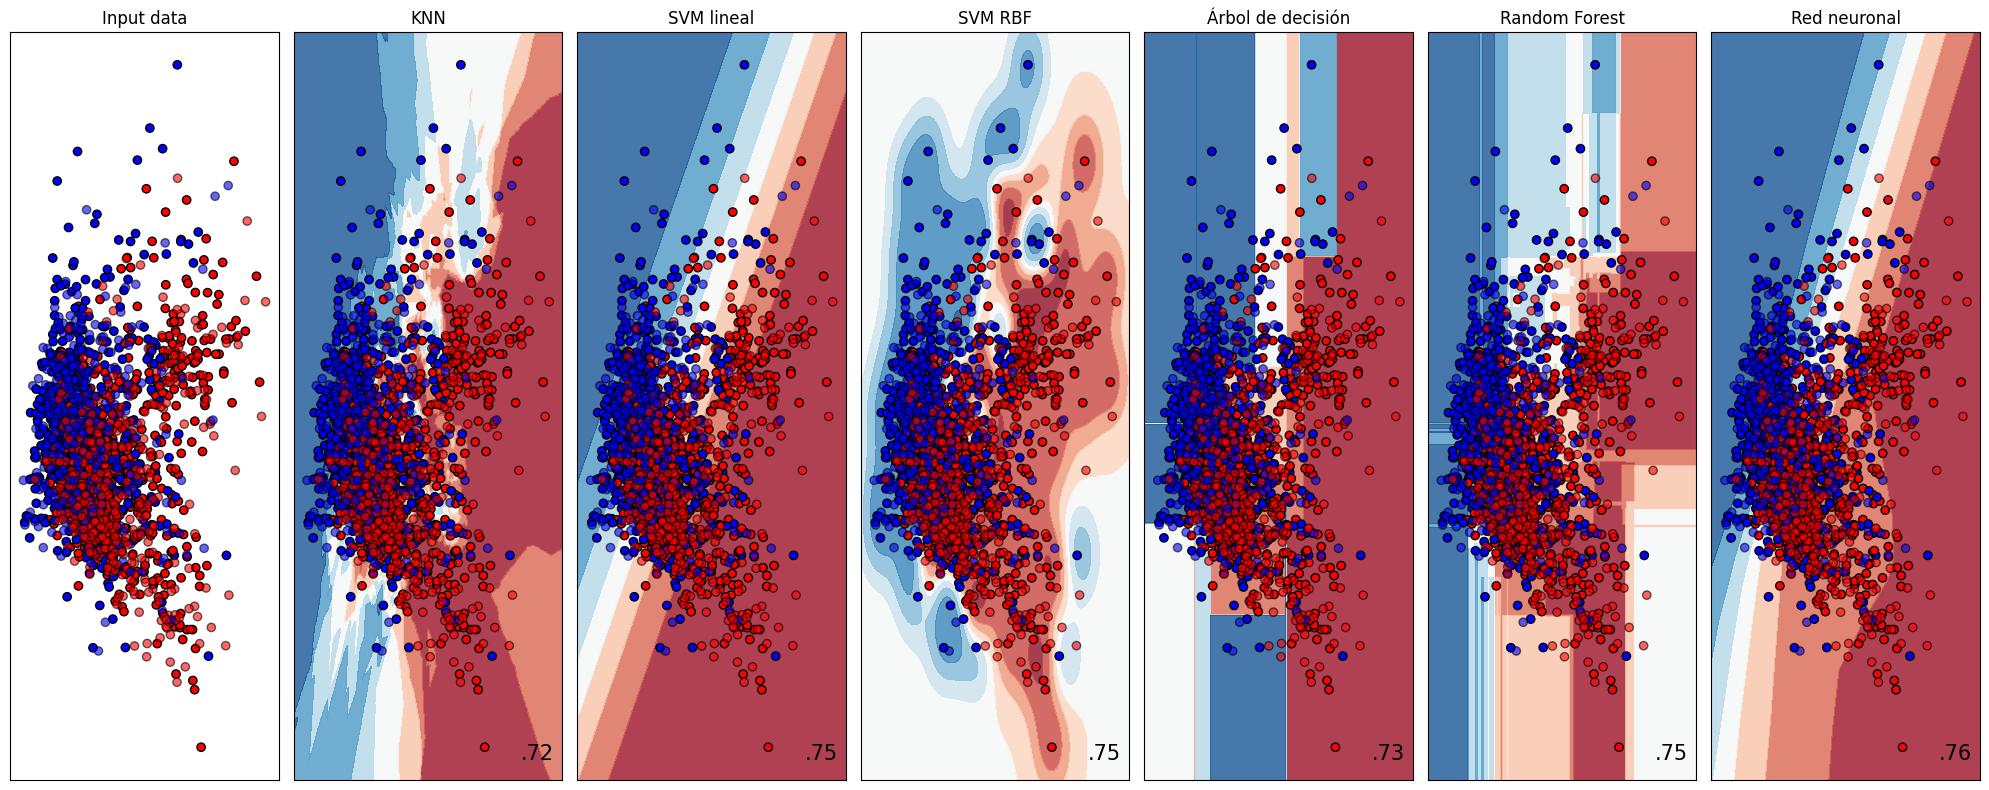

In [20]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Definamos la matriz X
campos = ['danceability','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo','duration_seg','positividad'] # Lista que contiene las features de interés
X = df_spotify[campos].values # En este caso no hace falta reshapear, porque ya tiene la forma que queremos
y = df_spotify['genre'] # Nuestra etiqueta sigue siende la misma de antes

# Escalar los datos
X = StandardScaler().fit_transform(X) 

# Reducir dimensionalidad con PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.4, random_state=42) 

# Configurar la figura
figure = plt.figure(figsize=(20, 8)) 
h = 0.02 # el paso de la grilla

x_min, x_max = X_pca[:, 0].min() - .5, X_pca[:, 0].max() + .5 # defino el rango de ejes x
y_min, y_max = X_pca[:, 1].min() - .5, X_pca[:, 1].max() + .5 # defino el rango de ejes y
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h)) # construyo una mella de puntos en ese rango

cm = plt.cm.RdBu # esto seleccion el tipo de color map (rojo-azul)
cm_bright = ListedColormap(['#FF0000', '#0000FF']) # construye el colormap entre esos dos colores

# Definir los clasificadores
names = ["KNN", "SVM lineal", "SVM RBF", "Árbol de decisión", "Random Forest", "Red neuronal"]
classifiers = [
    KNeighborsClassifier(7),
    SVC(kernel="linear", C=0.025, probability=True),
    SVC(gamma=2, C=1, probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
]

# Crear una cuadrícula de subplots
fig, axes = plt.subplots(1, len(classifiers) + 1, figsize=(20, 8))

# Primer subplot: datos de entrada
ax = axes[0]
ax.set_title("Input data") 
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k') # plotea datos de entrenamiento
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors='k') # plotea datos de evaluacion
ax.set_xlim(xx.min(), xx.max()) # pone limites
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())

for k, (name, clf) in enumerate(zip(names, classifiers)):
    clf.fit(X_train, y_train) # entreno
    score = clf.score(X_test, y_test) # evaluo

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1] # predice las probabilidades sobre cada par de puntos de la grilla
    Z = Z.reshape(xx.shape) # le da el formato adecuado para plotear el mapa de colores

    ax = axes[k + 1]
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8) # plotea el mapa de colores

    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors='k') # plotea puntos de entrenamiento
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, edgecolors='k', alpha=0.6) # plotea puntos de evaluacion

    ax.set_xlim(xx.min(), xx.max()) # rango en x
    ax.set_ylim(yy.min(), yy.max()) # rango en y
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name) # pone titulo
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')

plt.tight_layout()
plt.show()

# Conclusión
Como conclusión final se puede decir que es posible una clasificacion por genero partiendo de los datos obtendios por las API de Spotify y haciendo un poco de scraping. Es cierto que los resultados obtenidos en este proyecto se podrian mejorar ampliando el dataset o afinando los hiperparametros del modelo pero los resultados obtenidos son satisfactorios para esta primera versión.